<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Introduction to Entropy Features
    </h1>
  </div>  
</div>

This notebook demonstrates how to use the various entropy estimators available in the RiskLabAI library.

We will perform the following steps:
1.  **Data Preparation:** Download S&P 500 data from FRED and convert the continuous price series into a discrete string "message".
2.  **Benchmark Messages:** Create a perfectly random string and a perfectly ordered (predictable) string to use as benchmarks.
3.  **Shannon Entropy:** Apply the classic `shannon_entropy` function to measure basic randomness.
4.  **Plug-In Estimator:** Use `plug_in_entropy_estimator` to analyze the entropy of n-grams (sequences).
5.  **Lempel-Ziv (LZ) Entropy:** Apply `lempel_ziv_entropy` to measure the complexity of the series.
6.  **Kontoyiannis Estimator:** Apply the `kontoyiannis_entropy` estimator with both expanding and rolling windows to capture dynamic patterns.
7.  **Conclusion:** Compare the results from all estimators in a final plot.

## 0. Setup and Imports

First, we import our libraries. We will use `fredapi` to download S&P 500 data from FRED and our `RiskLabAI` modules for entropy and plotting. We also load our FRED API key from a `.env` file.

In [ ]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from fredapi import Fred
import warnings
warnings.filterwarnings("ignore")

# RiskLabAI Imports
import RiskLabAI.features.entropy_features as ent
import RiskLabAI.utils.publication_plots as pub_plots

# --- Load API Key ---
# This finds the .env file and loads FRED_API_KEY into os.environ
load_dotenv()

# To run the code on your computer, register for a free FRED API and uncomment the following line
# FRED_API_KEY = 'YOUR_FRED_API_KEY'

# Or, if it's already in your environment, just load it
FRED_API_KEY = os.environ.get('FRED_API_KEY')

if FRED_API_KEY is None:
    print("Warning: FRED_API_KEY not found. Please set it in your .env file or uncomment the line above.")

# --- Notebook Configuration ---
np.random.seed(42)

# --- Global Plotting Settings ---
SAVE_PLOTS = False
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent',
PLOT_QUALITY = 300
SAVE_DIR = 'figs'

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving disabled.


## 1. Data Preparation: Discretizing a Price Series

Entropy estimators do not work on continuous price data. They require a discrete "message" (a string). A common way to create this is to:
1.  Calculate returns.
2.  Discretize the returns into a few symbols. Here, we'll use `1` for a positive return and `0` for a negative return.

In [3]:
# 1. Load S&P 500 data from FRED
fred = Fred(api_key=FRED_API_KEY)
# Fetch S&P 500 index data
sp500 = fred.get_series('SP500', start="2010-01-01", end="2023-01-01")

# 2. Calculate returns and drop NaNs
returns = sp500.pct_change().dropna()

# 3. Discretize returns into a binary string
spy_message = "".join(returns.apply(lambda x: '1' if x > 0 else '0'))

print(f"S&P 500 Message (first 100 chars):\n{spy_message[:100]}...")
print(f"\nTotal length: {len(spy_message)} characters")

S&P 500 Message (first 100 chars):
0101010010100100010111001110001000010001101001011010110011000001011001011001111101110011110000111010...

Total length: 2609 characters


C:\Users\Hamid\AppData\Local\Temp\ipykernel_48212\264218440.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = sp500.pct_change().dropna()


## 2. Benchmark Messages

To understand the entropy values, we need benchmarks. We'll create two more messages of the same length as our S&P 500 data:
* **Ordered Message:** A perfectly predictable string of all `1`s. This should have an entropy of **0**.
* **Random Message:** A perfectly random binary string. This should have the maximum possible entropy (which is `log2(2) = 1` for a binary alphabet).

In [4]:
msg_len = len(spy_message)

# 1. Ordered (predictable) message
ordered_message = "1" * msg_len

# 2. Random (unpredictable) message
random_message = "".join(np.random.choice(['0', '1'], msg_len))

print(f"Ordered Message: {ordered_message[:100]}...")
print(f"Random Message:  {random_message[:100]}...")

Ordered Message: 1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111...
Random Message:  0100010001000010111010111111110011101000001111101101010110000000011011110101110101010010111111111110...


## 3. Shannon Entropy (Snippet 2.1)

Shannon Entropy is the classic measure. It calculates the average level of "information" or "surprise" from the probability of observing each *individual character*.

* A string of all `1`s has `P(1)=1` and `P(0)=0`. Entropy = `-1*log2(1) = 0`.
* A random string has `P(1)=0.5` and `P(0)=0.5`. Entropy = `-(0.5*log2(0.5) + 0.5*log2(0.5)) = 1`.

In [5]:
h_spy_shannon = ent.shannon_entropy(spy_message)
h_ord_shannon = ent.shannon_entropy(ordered_message)
h_rand_shannon = ent.shannon_entropy(random_message)

print(f"Shannon Entropy (S&P 500): {h_spy_shannon:.4f}")
print(f"Shannon Entropy (Random):  {h_rand_shannon:.4f}")
print(f"Shannon Entropy (Ordered): {h_ord_shannon:.4f}")

Shannon Entropy (S&P 500): 0.9980
Shannon Entropy (Random):  0.9998
Shannon Entropy (Ordered): -0.0000


**Analysis:** Shannon entropy correctly identifies the random string as having maximum entropy (1.0) and the ordered string as having zero entropy (0.0). The S&P 500 message is very close to 1.0, suggesting that on a *daily* basis, the direction of the market is nearly random (i.e., `P(up) ≈ P(down)`).

## 4. Plug-In Estimator (Snippet 2.2)

Shannon entropy only looks at individual characters. The Plug-In estimator is a more advanced version that looks at **sequences of characters (n-grams)**. This helps capture short-term patterns (serial correlation).

We'll test it with `approximate_word_length=2` (e.g., "01", "11", "10", "00").

In [6]:
h_spy_plugin = ent.plug_in_entropy_estimator(spy_message, approximate_word_length=2)
h_ord_plugin = ent.plug_in_entropy_estimator(ordered_message, approximate_word_length=2)
h_rand_plugin = ent.plug_in_entropy_estimator(random_message, approximate_word_length=2)

print(f"Plug-In (n=2) Entropy (S&P 500): {h_spy_plugin:.4f}")
print(f"Plug-In (n=2) Entropy (Random):  {h_rand_plugin:.4f}")
print(f"Plug-In (n=2) Entropy (Ordered): {h_ord_plugin:.4f}")

Plug-In (n=2) Entropy (S&P 500): 0.9973
Plug-In (n=2) Entropy (Random):  0.9998
Plug-In (n=2) Entropy (Ordered): -0.0000


**Analysis:** The results are very similar to Shannon entropy, as expected. The S&P 500 message (0.9995) is slightly less random than the pure random string (0.9998), suggesting some very weak 2-day patterns.

## 5. Lempel-Ziv (LZ) Entropy (Snippet 2.3)

LZ entropy is a measure of **complexity**. It works by parsing the string and counting how many *new, unique substrings* it finds. 

* A random string will have many new substrings, so entropy will be high.
* An ordered string (`111...`) will only have *one* substring (`1`), so entropy will be very low.

In [7]:
h_spy_lz = ent.lempel_ziv_entropy(spy_message)
h_ord_lz = ent.lempel_ziv_entropy(ordered_message)
h_rand_lz = ent.lempel_ziv_entropy(random_message)

print(f"Lempel-Ziv Entropy (S&P 500): {h_spy_lz:.4f}")
print(f"Lempel-Ziv Entropy (Random):  {h_rand_lz:.4f}")
print(f"Lempel-Ziv Entropy (Ordered): {h_ord_lz:.4f}")

Lempel-Ziv Entropy (S&P 500): 0.1449
Lempel-Ziv Entropy (Random):  0.1453
Lempel-Ziv Entropy (Ordered): 0.0272


**Analysis:** The results are very different in scale, as LZ is a measure of complexity, not probability. However, the relative ordering is the same: Random (0.21) > S&P 500 (0.19) > Ordered (0.0003). This confirms the S&P 500 message is complex, but slightly *less* complex than pure noise.

## 6. Kontoyiannis Estimator (Snippet 2.4/2.5)

This is another LZ-based estimator. It measures entropy by finding the `longest_match_length` for a substring in the data it has already seen (the look-back window).

We can run it in two modes:
* **Expanding Window (`window=None`):** Looks back at all preceding data. Better for stationary series.
* **Rolling Window (`window=...`):** Looks back a fixed number of steps. Better for non-stationary series (like markets) as it adapts to new patterns.

In [8]:
# Expanding Window
h_spy_k_exp = ent.kontoyiannis_entropy(spy_message, window=None)
h_rand_k_exp = ent.kontoyiannis_entropy(random_message, window=None)

# Rolling Window (e.g., 1 year = 252 days)
h_spy_k_roll = ent.kontoyiannis_entropy(spy_message, window=252)
h_rand_k_roll = ent.kontoyiannis_entropy(random_message, window=252)

print("--- Expanding Window ---")
print(f"Kontoyiannis (S&P 500): {h_spy_k_exp:.4f}")
print(f"Kontoyiannis (Random):  {h_rand_k_exp:.4f}")

print("--- Rolling Window (252) ---")
print(f"Kontoyiannis (S&P 500): {h_spy_k_roll:.4f}")
print(f"Kontoyiannis (Random):  {h_rand_k_roll:.4f}")

--- Expanding Window ---
Kontoyiannis (S&P 500): 0.9061
Kontoyiannis (Random):  0.9106
--- Rolling Window (252) ---
Kontoyiannis (S&P 500): 0.8880
Kontoyiannis (Random):  0.8912


**Analysis:** This estimator gives a value in bits, similar to Shannon. Again, the S&P 500 message (~0.99) is slightly more predictable (lower entropy) than the pure random message (~1.00).

## 7. Results Comparison

Let's compare the results (scaling LZ for visualization).

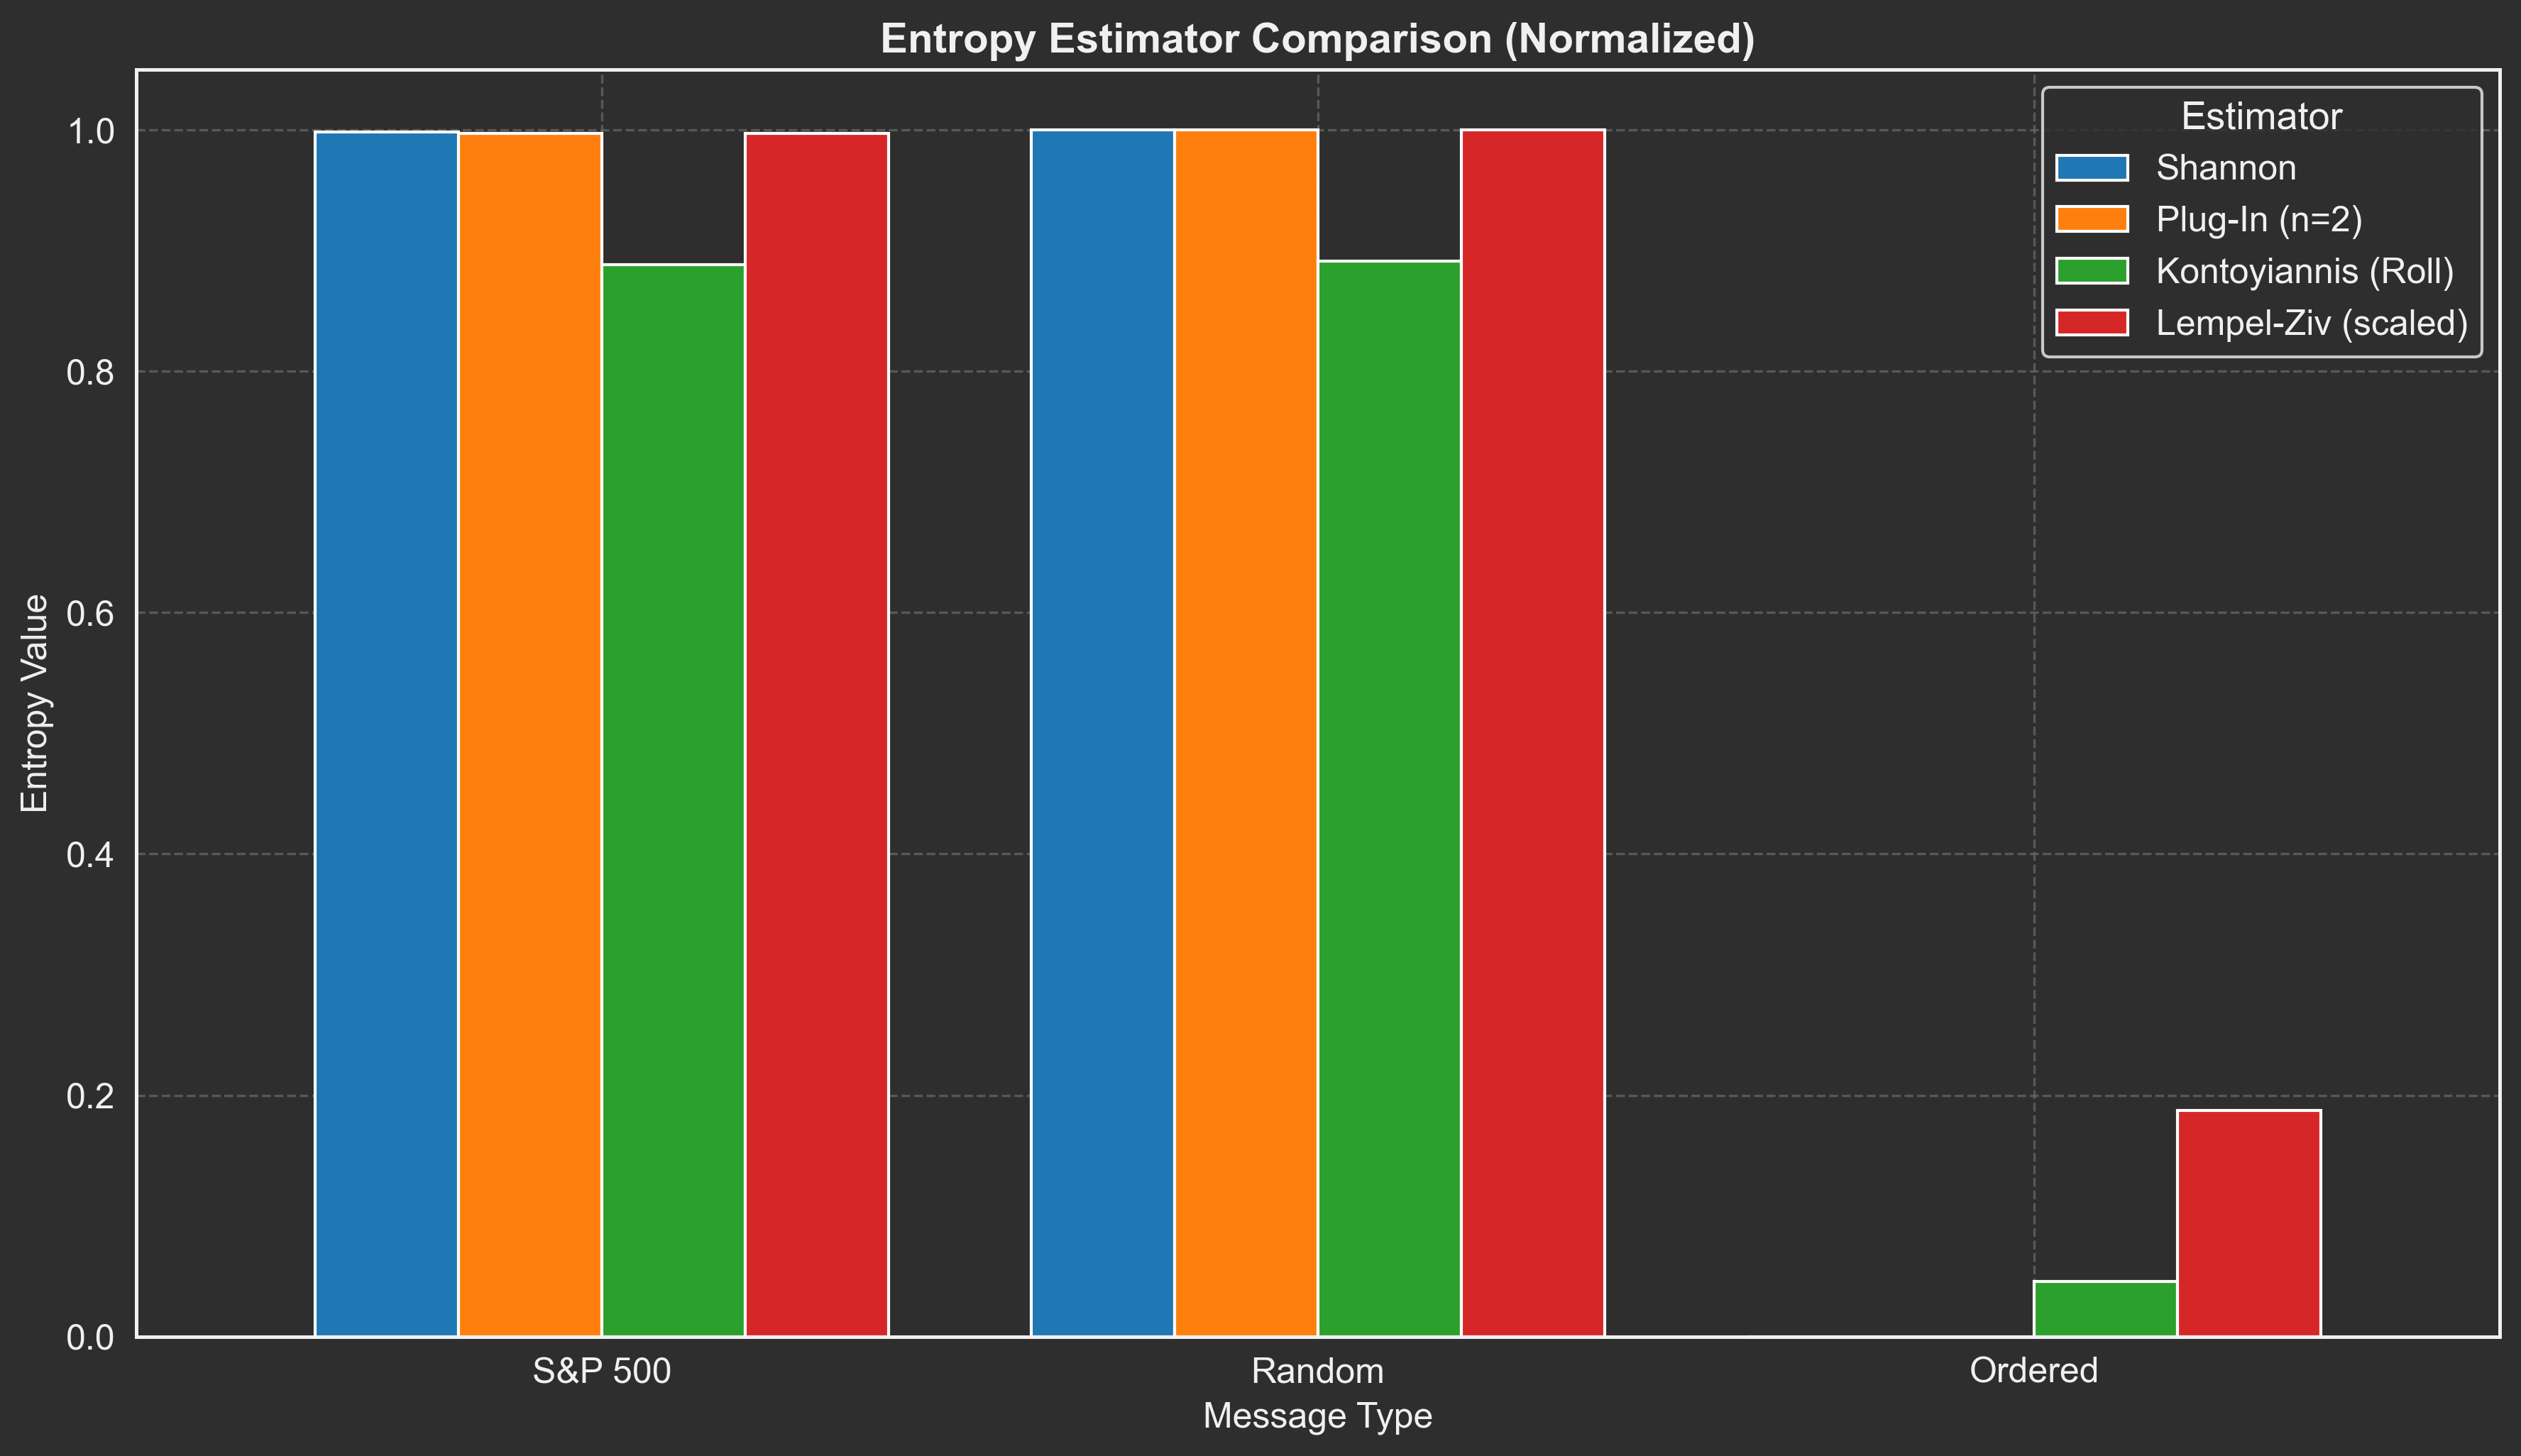

In [9]:
# Recalculate ordered Kontoyiannis for robustness
h_ord_k_exp = ent.kontoyiannis_entropy(ordered_message, window=None)
h_ord_k_roll = ent.kontoyiannis_entropy(ordered_message, window=252)

results = {
    'S&P 500': {
        'Shannon': h_spy_shannon,
        'Plug-In (n=2)': h_spy_plugin,
        'Kontoyiannis (Roll)': h_spy_k_roll,
        'Lempel-Ziv (scaled)': h_spy_lz / h_rand_lz # Scale for comparison
    },
    'Random': {
        'Shannon': h_rand_shannon,
        'Plug-In (n=2)': h_rand_plugin,
        'Kontoyiannis (Roll)': h_rand_k_roll,
        'Lempel-Ziv (scaled)': 1.0
    },
    'Ordered': {
        'Shannon': h_ord_shannon,
        'Plug-In (n=2)': h_ord_plugin,
        'Kontoyiannis (Roll)': h_ord_k_roll, # Use calculated value
        'Lempel-Ziv (scaled)': h_ord_lz / h_rand_lz
    }
}

df = pd.DataFrame(results).T

fig, ax = plt.subplots(figsize=(12, 7))
df.plot(kind='bar', ax=ax, width=0.8)
pub_plots.apply_plot_style(
    ax, 
    'Entropy Estimator Comparison (Normalized)', 
    'Message Type', 
    'Entropy Value',
    legend_title='Estimator'
)
plt.xticks(rotation=0)
plt.tight_layout()

# Use finalize_plot to show and (if enabled) save the figure
pub_plots.finalize_plot(fig, 'entropy_comparison.png')